## Normalisation and Augmentation in Medical Imaging
An essential preprocessing step in medical imaging (especially with MRI images) is intensity normalisation. Below we demonstrate some standard options for normalisation and data augmentation. The latter has become extremely critical in deep learning applications.

### Data normalisation
Below are some basic examples for data normalisation implemented in DLTK.

In [1]:
import SimpleITK as sitk
import os
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

import pandas as pd

Fetch a single MRI image using part of the reader function defined in the data io notebook

In [2]:
# Read subject information and data paths
data_path = '../../data/IXI_HH/1mm'
all_filenames = pd.read_csv(
    '../../data/IXI_HH/demographic_HH.csv',
    dtype=object,
    keep_default_na=False,
    na_values=[]).as_matrix()

# Keep the first subject
first_subject = all_filenames[0]

# Here, we parse the `subject_id` to construct a file path to read
# an image from.
subject_id = first_subject[0]
data_path = '../../data/IXI_HH/1mm'
t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))

# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
sitk_t1 = sitk.ReadImage(t1_fn)
t1 = sitk.GetArrayFromImage(sitk_t1)

Different normalisation techniques

In [3]:
# Normalise the image to zero mean/unit std dev:
t1_white = whitening(t1)

# Normalise the image to fit [0, 1] range:
t1_norm_zo = normalise_zero_one(t1)

# Normalise the image to fit [-1, 1] range:
t1_norm_oo = normalise_one_one(t1)

Plot results

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_subfig_gray(pos, img, title):
    """
    Function to plot subfigures
    """
    plt.subplot(pos)
    plt.imshow(img, 'gray')
    plt.title(title)
    plt.colorbar()

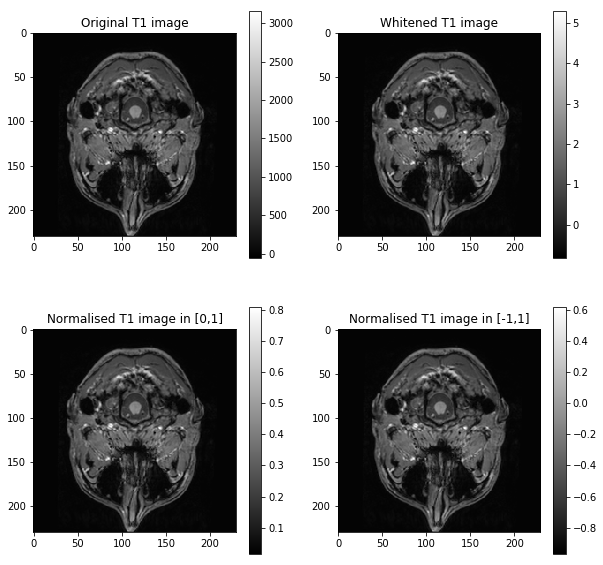

In [5]:
plt.figure(figsize=[10, 10])

# Plot each normalised image
plot_subfig_gray(221, t1[0], 'Original T1 image')
plot_subfig_gray(222, t1_white[0], 'Whitened T1 image')
plot_subfig_gray(223, t1_norm_zo[0], 'Normalised T1 image in [0,1]')
plot_subfig_gray(224, t1_norm_oo[0], 'Normalised T1 image in [-1,1]')

plt.show()

Crop or pad image

In [6]:
# Crop to default size [64, 64, 64]
t1_cropped = resize_image_with_crop_or_pad(t1, mode='symmetric')
print('Cropped image size is:')
print(t1_cropped.shape)

# Resizing image to [128, 256, 256] required padding
t1_padded = resize_image_with_crop_or_pad(t1, [128, 256, 256], mode='symmetric')
print('Resized image size is:')
print(t1_padded.shape)

Cropped image size is:
(64, 64, 64)
Resized image size is:
(128, 256, 256)


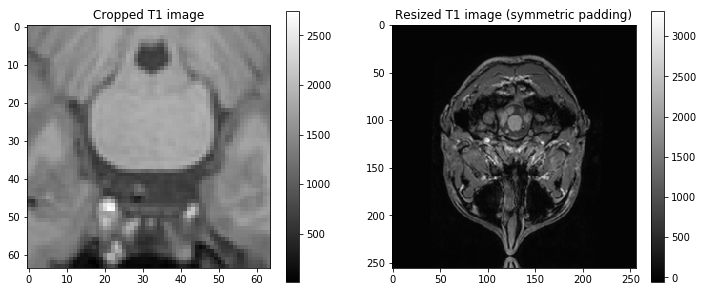

In [7]:
plt.figure(figsize=[12, 5])

plot_subfig_gray(121, t1_cropped[0], 'Cropped T1 image')
plot_subfig_gray(122, t1_padded[0], 'Resized T1 image (symmetric padding)')

plt.show()

### Data augmentation

Below we apply different augmentation techniques, which are commonly used for enriching the training dataset and training more robust deep learning models. These are applied to the whitened normalised image computed above.

In [8]:
# Flip image
t1_flipped = flip(np.array(t1_white), axis=1)

# Add Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(np.array(t1_white), sigma=0.25)

# Add Gaussian noise
t1_noise = add_gaussian_noise(np.array(t1_white), sigma=0.25)

# Elastic transforms according to:
# [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
#     Neural Networks applied to Visual Document Analysis", in Proc. of the
#     International Conference on Document Analysis and Recognition, 2003.
t1_trans_low_s = elastic_transform(t1_white, [1, 25, 25], [1, 10, 10])
t1_trans_high_s = elastic_transform(t1_white, [1, 10, 10], [1, 25, 25])

Plot results of the different augmentations techniques

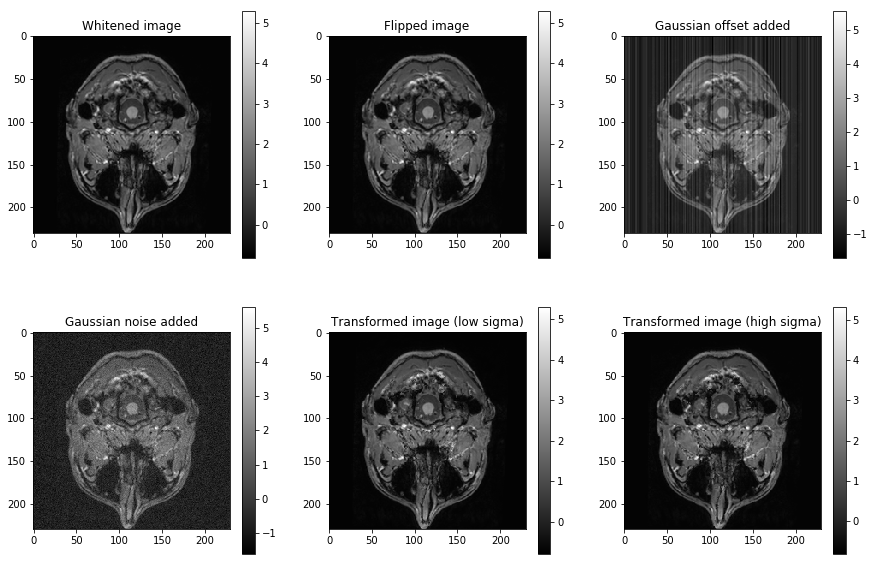

In [9]:
plt.figure(figsize=[15, 10])

plot_subfig_gray(231, t1_white[0], 'Whitened image')
plot_subfig_gray(232, t1_flipped[0], 'Flipped image')
plot_subfig_gray(233, t1_offset[0], 'Gaussian offset added')
plot_subfig_gray(234, t1_noise[0], 'Gaussian noise added')
plot_subfig_gray(235, t1_trans_low_s[0], 'Transformed image (low sigma)')
plot_subfig_gray(236, t1_trans_high_s[0], 'Transformed image (high sigma)')

plt.show()

Plot difference between elastic transformed images and original whitened image

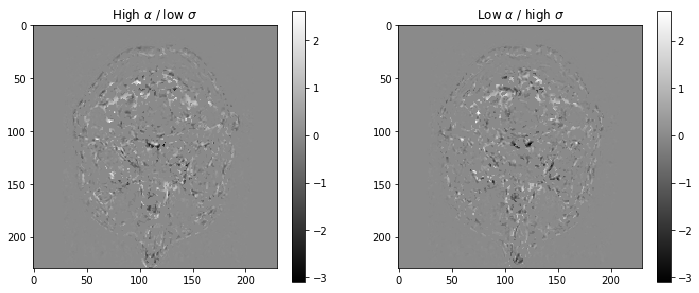

In [10]:
plt.figure(figsize=[12, 5])

plot_subfig_gray(121, (t1_white-t1_trans_low_s)[0], r'High $\alpha$ / low $\sigma$')
plot_subfig_gray(122, (t1_white-t1_trans_high_s)[0], r'Low $\alpha$ / high $\sigma$')

plt.show()